# Profiling with PyTorch

In [2]:
import os
from typing import Sequence, Tuple
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchmetrics.functional as metrics
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

%matplotlib inline

DATA_PATH = os.getenv('TEACHER_DIR', os.getcwd()) + '/JHL_data'

## What is profiling?

According to [wikipedia](https://en.wikipedia.org/wiki/Profiling_(computer_programming)): 

"Profiling is a form of dynamic program analysis that measures, for example, the space (memory) or time complexity of a program, the usage of particular instructions, or the frequency and duration of function calls. Most commonly, profiling information serves to aid program optimization, and more specifically, performance engineering."

What this means is that you analyse your program, trying to identify bottlenecks, and thereby optimizing it's execution. As an example, you might have an application needs to read a lot of input data (quite typical in machine learning!) during its run. A profile might show you that while your code runs, your processor is mostly idling since it is waiting for input data. This might give you a hint on how to optimize your program: maybe you can read in _part_ of the input, and already start computing on that _while_ you're loading in your next samples. Or: maybe you can copy your data to a faster disk, before you start running.

## Why should I care about profiling?

You may know that training large models like GPT-3 takes several _million_ dollars [source](https://lambdalabs.com/blog/demystifying-gpt-3/) and a few hundred MWh [source](https://www.theregister.com/2020/11/04/gpt3_carbon_footprint_estimate/). If the engineers that trained these models did _not_ spend time on optimization, it might have been several million dollars and hunderds of MWh more.

Sure, the model you'd like to train is probably not quite as big. But maybe you want to train it 10000 times, because you want to do hyperparameter optimization. And even if you only train it once, it may take quite a bit of compute resources, i.e. money and energy.

## When should I care about profiling?

Well, you should _always_ care if your code runs efficiently, but there's different levels of caring.

From personal experience: if I know I'm going to run a code only once, for a few days, on a single GPU, I'll probably not create a full profile. What I _would_ do is inspect my GPU and CPU utilization during my runs, just to see if it is _somewhat_ efficient, and if I didn't make any obvious mistakes (e.g. accidentally _not_ using the GPU, even if I have one available).

If I know that I'll run my code on multiple GPUs, for multiple days, (potentially) on multiple nodes, and/or I need to run it multiple times, I know that my resource footprint is going to be large, and it's worth spending some time and effort to optimize the code. That's when I'll create a profile. The good part is: the more often you do it, the quicker and more adapt you become at it.

In [3]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move data and target to the gpu, if available and used
        data, target = map(lambda tensor: tensor.to(device, non_blocking=True), (data, target))
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        accuracy = metrics.accuracy(output, target)
        
        if batch_idx % log_interval == 0:
            print(
                f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100 * batch_idx / len(train_loader):.0f}%)]'
                f'\tLoss: {loss.detach().item():.6f}'
                f'\tAccuracy: {accuracy.detach().item():.2f}'
            )

        yield loss.detach().item(), accuracy.detach().item() 


@torch.no_grad()
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    for data, target in test_loader:
        # move data and target to the gpu, if available and used
        data, target = map(lambda tensor: tensor.to(device, non_blocking=True), (data, target))

        # get model output
        output = model(data)

        # calculate loss
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

        # get most likely class label
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # count the number of correct predictions
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))
    
    yield test_loss, correct / len(test_loader.dataset)

### Function to run training and testing loops

In [4]:
def fit(model, optimizer, n_epochs, device, train_loader, test_loader, log_interval):

    # get the validation loss and accuracy of the untrained model
    start_val_loss, start_val_acc = tuple(test(model, device, test_loader))[0]

    # don't mind the following train/test loop logic too much, if you want to know what's happening, let us know :)
    # normally you would pass a logger to your train/test loops and log the respective metrics there
    (train_loss, train_acc), (val_loss, val_acc) = map(lambda arr: np.asarray(arr).transpose(2,0,1), zip(*[
        (
            [*train(model, device, train_loader, optimizer, epoch, log_interval)],
            [*test(model, device, test_loader)]
        )
        for epoch in range(n_epochs)
    ]))

    # flatten the arrays
    train_loss, train_acc, val_loss, val_acc = map(np.ravel, (train_loss, train_acc, val_loss, val_acc))

    # prepend the validation loss and accuracy of the untrained model
    val_loss, val_acc = (start_val_loss, *val_loss), (start_val_acc, *val_acc)

    plot_metric_curve(train_loss, val_loss, n_epochs, 'Loss')
    plot_metric_curve(train_acc, val_acc, n_epochs, 'Accuracy')

# Defining the model
Moving from a FCNN to a CNN, we split our model in two: a feature extractor and a classifier.  
The classifier will be no different to the FCNN: Some linear layers with a non-linearity in-between.  
The feature extractor will be our convolutional layers, with a downsampling operation after each layer; in our case max-pooling.  
(Which you shouldn't normally use unless you have a very good reason to! Take it from Saint Geoff:
https://mirror2image.wordpress.com/2014/11/11/geoffrey-hinton-on-max-pooling-reddit-ama/) )

In [5]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 4 convolution layers, with a non-linear activation after each.
        # maxpooling after the activations of the 2nd, 3rd, and 4th conv layers
        # 2 dense layers for classification
        # log_softmax
        #
        # As for the number of channels of each layers, try to experiment!

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # in_features of the first layer should be the product of the output shape of your feature extractor!
        # E.g. if the output of your feature extractor has size (batch x 128 x 4 x 4), in_features = 128*4*4=2048
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=10),
            nn.LogSoftmax(dim=1)
        )



    def forward(self, x):
        features = self.feature_extractor(x)
        
        return self.classifier(features)


### Function to plot train/validation curves

In [6]:
def plot_metric_curve(
    train_metric: Sequence[float], 
    val_metric: Sequence[float],
    n_epochs: int,
    metric_name: str, # Label of the y-axis, e.g. 'Accuracy'
    x_axis_name: str = 'Epoch'
):
    # create values for the x-axis
    train_steps, val_steps = map(
        lambda metric_values: np.linspace(start=0, stop=n_epochs, num=len(metric_values)),
        (train_metric, val_metric)
    )
    
    plt.plot(train_steps, train_metric, label='train')
    plt.plot(val_steps, val_metric, label='validation')
    plt.title(f"{metric_name} vs. {x_axis_name}")
    plt.legend()
    plt.show()

### PyTorch boilerplate

In [7]:
use_cuda = torch.cuda.is_available()
print(f"CUDA is {'' if use_cuda else 'not '}available")
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
    torch.cuda.set_per_process_memory_fraction(0.22)

#cpu_count = len(os.sched_getaffinity(0))
cpu_count=1

CUDA is available


### Results
Achieving ~75% validation accuracy with our simple CNN Classifier should be possible, how did you do? Let us know!

- Do you see a difference in train accuracy and validation accuracy?
- How does the difference between training and validation accuracy change over time?

The State-of-the-art is currently 99.5% accuracy! (See https://paperswithcode.com/sota/image-classification-on-cifar-10)

One of the areas of improvement is that our model is still not very deep, modern models usually range from 18-50 layers.
However, after around ~15 layers, you start to run into some issues with information propagation through your model: the gradient of the loss is not able to reach the first few layers of the model.

Checkout https://arxiv.org/pdf/1512.03385.pdf for the seminal paper fixing this issue.

### Next chapter: So we can classify images, but can we also generate new ones? Introducing the VAE 

## Train with profiling

In [8]:
def train_profiling(model, device, train_loader, optimizer, epoch, log_interval, logdir):
    model.train()
    
    # Create a torch.profiler.profile object, and call it as the last part of the training loop
    with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=1,
        active=10),
    on_trace_ready=torch.profiler.tensorboard_trace_handler(logdir, worker_name='worker0'),
    record_shapes=True,
    profile_memory=True,  # This will take 1 to 2 minutes. Setting it to False could greatly speedup.
    with_stack=True
) as p:
        for batch_idx, (data, target) in enumerate(train_loader):
            # move data and target to the gpu, if available and used
            data, target = map(lambda tensor: tensor.to(device, non_blocking=True), (data, target))
            
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        
            accuracy = metrics.accuracy(output, target)
        
            if batch_idx % log_interval == 0:
                print(
                    f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100 * batch_idx / len(train_loader):.0f}%)]'
                    f'\tLoss: {loss.detach().item():.6f}'
                    f'\tAccuracy: {accuracy.detach().item():.2f}'
                )

            yield loss.detach().item(), accuracy.detach().item() 
            
            p.step()
            
@torch.no_grad()
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    for data, target in test_loader:
        # move data and target to the gpu, if available and used
        data, target = map(lambda tensor: tensor.to(device, non_blocking=True), (data, target))

        # get model output
        output = model(data)

        # calculate loss
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

        # get most likely class label
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # count the number of correct predictions
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))
    
    yield test_loss, correct / len(test_loader.dataset)

In [9]:
def fit_profiling(model, optimizer, n_epochs, device, train_loader, test_loader, log_interval, logdir):

    # get the validation loss and accuracy of the untrained model
    start_val_loss, start_val_acc = tuple(test(model, device, test_loader))[0]

    # don't mind the following train/test loop logic too much, if you want to know what's happening, let us know :)
    # normally you would pass a logger to your train/test loops and log the respective metrics there
    (train_loss, train_acc), (val_loss, val_acc) = map(lambda arr: np.asarray(arr).transpose(2,0,1), zip(*[
        (
            [*train_profiling(model, device, train_loader, optimizer, epoch, log_interval, logdir)],
            [*test(model, device, test_loader)]
        )
        for epoch in range(n_epochs)
    ]))

    # flatten the arrays
    train_loss, train_acc, val_loss, val_acc = map(np.ravel, (train_loss, train_acc, val_loss, val_acc))

    # prepend the validation loss and accuracy of the untrained model
    val_loss, val_acc = (start_val_loss, *val_loss), (start_val_acc, *val_acc)

    plot_metric_curve(train_loss, val_loss, n_epochs, 'Loss')
    plot_metric_curve(train_acc, val_acc, n_epochs, 'Accuracy')

Here, we create our own dataset object, that reads png files from a directory, and the labels from a single pkl. This pkl contains a dictionary where the filenames are keys, and the labels ar the values. Thus, to get the label from the dictionary, we can simply index it with the base filename.

In [10]:
import pickle
import glob
from torchvision.io import read_image
from PIL import Image
        
class Cifar10PNGDataset(Dataset):
    def __init__(self, label_file, img_dir, transform=None, target_transform=None):
        # Load labels
        with open(label_filename, 'rb') as fo:
            self.label_dict = pickle.load(fo, encoding='bytes')
        # List filenames with png extension
        self.img_filenames = glob.glob(os.path.join(img_dir, '*.png'))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.label_dict)
    
    def __getitem__(self, idx):
        # Get filename with index idx:
        img_filename = self.img_filenames[idx]
        # Read file from disk
        # image = read_image(img_filename)
        image = Image.open(img_filename)
        # Read label from label dictionary
        label = self.label_dict[os.path.basename(img_filename)]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
        

Let's create the training dataset, and display one sample with its label to verify we did everything correctly

Label: 6
(0 = airplane, 1 = automobile, 2 = bird, 3 = cat, 4 = deer, 5 = dog, 6 = frog, 7 = horse, 8 = ship, 9 = truck)


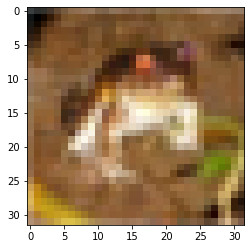

In [11]:
PNG_DATA = os.path.join(DATA_PATH, 'cifar10_png')
label_filename = os.path.join(DATA_PATH, "labels.pkl")
train_dataset = Cifar10PNGDataset(label_file = label_filename, img_dir = PNG_DATA)

# Inspect one image and one label as example:
img_sample = train_dataset[0][0]
label_sample = train_dataset[0][1]

#plt.imshow(img_sample.permute(1,2,0))
plt.imshow(img_sample)
print(f"Label: {label_sample}")
print(f"(0 = airplane, 1 = automobile, 2 = bird, 3 = cat, 4 = deer, 5 = dog, 6 = frog, 7 = horse, 8 = ship, 9 = truck)")

In [ ]:
BATCH_SIZE = 600
EPOCHS = 1
LEARNING_RATE = 1e-4

LOGGING_INTERVAL = 10  # Controls how often we print the progress bar

model = CIFAR10CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # optim.<OPTIMIZER_FLAVOUR>(model.parameters(), lr=LEARNING_RATE)

transform=transforms.Compose([
    transforms.ToTensor(),
    # Normalize the data to 0 mean and 1 standard deviation, now for all channels of RGB
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

PNG_DATA = os.path.join(DATA_PATH, 'cifar10_png')
label_filename = os.path.join(DATA_PATH, "labels.pkl")
train_dataset = Cifar10PNGDataset(label_file = label_filename, img_dir = PNG_DATA, transform=transform)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=use_cuda,
        shuffle=True,
        num_workers=cpu_count
)

test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(DATA_PATH, train=False, transform=transform, download=True),
        batch_size=BATCH_SIZE,
        pin_memory=use_cuda,
        shuffle=False,
        num_workers=cpu_count
)

#train_profiling(model, device, train_loader, optimizer, 0, log_interval=10)

logdir = "logs/baseline_1_40/" + datetime.now().strftime("%Y%m%d-%H%M%S")

fit_profiling(model, optimizer, EPOCHS, device, train_loader, test_loader, LOGGING_INTERVAL, logdir)

Files already downloaded and verified

Test set: Average loss: 2.3028, Accuracy: 967/10000 (10%)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.302634	Accuracy: 0.10
Train Epoch: 0 [6000/50000 (12%)]	Loss: 2.265243	Accuracy: 0.15
Train Epoch: 0 [12000/50000 (24%)]	Loss: 2.180698	Accuracy: 0.28
Train Epoch: 0 [18000/50000 (36%)]	Loss: 2.067499	Accuracy: 0.30


In [ ]:
%%capture --no-stdout

import random, os

rand_port = random.randint(6000, 8000)
username = os.getenv('USER')
#full_logdir=os.path.join(os.getcwd(), logdir)

# Kill old TensorBoard sessions
!kill -9 $(pgrep -u $username tensorboard)

%reload_ext tensorboard
# Run with --load_fast=false, since current TensorBoard version has an issue with the profiler plugin
# (more info https://github.com/tensorflow/tensorboard/issues/4784)
%tensorboard --logdir=$logdir --port=$rand_port --load_fast=false

print(f"Go to https://jupyter.lisa.surfsara.nl/jhlsrf016/user/{username}/proxy/{rand_port}/#pytorch_profiler")